In [433]:
from __future__ import division
import numpy as np
import numpy.ma as nma
from pio import imgio
import apply_mask
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib import colors as clr
rc('text', usetex=True)
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit
from scipy.signal import correlate2d
from lmfit import Model
from pydmd import DMD
from pydmd import FbDMD
from copy import deepcopy
import cv2
import cmap_sunset
from datetime import datetime
%matplotlib inline

In [238]:
path = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/'
img_file = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.img'
W_file = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.npz'
U_file = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.W.npz'
instantaneous_mask_file = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.mask.npz'
time_avg_mask_file= '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.mask.tave_mask.npz'
Wave_file = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.ave.npz'
Wrms_file = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.rms.npz'

Uave_file = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.ave.npz'
Urms_file = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.rms.npz'

deltat = 1/500 #s
cal = 3581 #pix/m
D_0 = 1.905e-2 #m
dx = 24
outlet_z_pix = 197

In [3]:
img = imgio.imgio(img_file)

# Mean Velocity

In [4]:
W_inst = apply_mask.apply_mask(W_file,instantaneous_mask_file)
W_mean = apply_mask.apply_mask(Wave_file,time_avg_mask_file)

In [5]:
x = np.arange(0+dx, img.ix-dx,dx)
y = np.arange(0+dx,img.iy-dx,dx)
X,Y = np.meshgrid(x,y)

(5050, 5120)

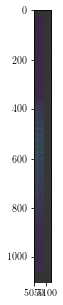

In [516]:
f,ax = plt.subplots(figsize=(5*img.ix/img.iy,5*1))
ax.pcolormesh(X,Y,W_mean.data,alpha=0.3)
ax.imshow(img.read_frame2d(1000),alpha=0.8,cmap=cm.gray)
ax.set_xlim(5050,img.read_frame2d(1000).shape[1])
#ax.set_ylim(1050,1100)

In [ ]:
x = np.arange(0+dx, img.ix-dx,dx)
y = np.arange(0+dx,img.iy-dx,dx)
X,Y = np.meshgrid(x,y)
plt.pcolormesh(W_mean/cal/deltat,cmap='sunset')
plt.colorbar()
plt.plot(((centerline[0])),(centerline[1]),'wx')
#plt.xlim(60,120)

In [49]:
mask_zlocs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,103,104,105,106,107,108,109,110,111]
additional_mask = np.load(time_avg_mask_file)['arr_0']
for c in mask_zlocs:
    additional_mask[:,c] = 1
W_mean = nma.masked_array(W_mean, mask=additional_mask)
np.savez_compressed(path+'tave_mask_edited.npz', additional_mask)

In [209]:
centerline = np.zeros((2,W_mean.shape[1]))
for r in range(0,W_mean.shape[1]):
    centerline[0,r] = int(r)#((r*dx+dx+0.5)-outlet_z_pix)
    try:
        centerline[1,r] = int(np.where(W_mean[:,r] == nma.max(W_mean[:,:],axis=0)[r])[0])
    except:
        centerline[1,r] = np.nan
np.savez_compressed(path+'figures/centerline_W.npz',nma.max(W_mean[:,:],axis=0)[~np.isnan(centerline[1])].data/cal/deltat)
centerline = centerline[:,~np.isnan(centerline[1])].astype('int')
np.savez_compressed(path+'figures/centerline_xz_pos.npz',centerline)

In [187]:
W_centerline = np.load(path+'figures/centerline_W.npz')['arr_0']
centerline = np.load(path+'figures/centerline_xz_pos.npz')['arr_0']

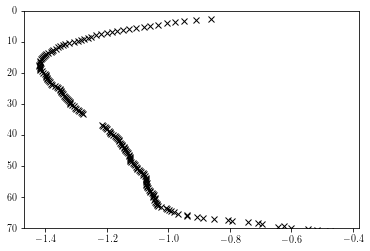

In [302]:
plt.plot(-W_centerline,((centerline[0]*dx+dx+0.5)-outlet_z_pix)/cal/D_0,'kx')
plt.ylim(70,0);

# Concentration

In [22]:
mean_c = img.read_frame2d(0).astype(int)
for f in range(1,img.it):
    t = img.read_frame2d(f)
    mean_c += t
mean_c = (mean_c / img.it)

In [538]:
len(slices), W_mean.shape[0]*W_mean.shape[1]

(9328, 9328)

In [405]:
c_map = np.zeros(W_inst.shape)
for f in range(0,W_inst.shape[0]):
    for r in range(int(dx),int(img.iy-(dx)),dx):
        for c in range(int(dx),int(img.ix - (dx)),dx):
            c_map[f,int(r/dx)-1,int(c/dx)-1] = np.mean(img.read_frame2d(f)[slice(r,r+dx,1),slice(c,c+dx,1)])


KeyboardInterrupt: 

In [555]:
n_row_slices = int((img.read_frame2d(0).shape[0]-2*dx)/dx)
n_col_slices = int((img.read_frame2d(0).shape[1]-dx)/dx)
slices = []
for i in x:
    for j in y:
        slices.append((slice(j,j+dx),slice(i,i+dx)))

In [ ]:
c_map = np.zeros(W_inst.shape)
tic = datetime.now()
for f in range(438,W_inst.shape[0]):
    for s in slices:
        c_map[f,int(s[0].start/dx-1),int(s[1].start/dx-1)] = np.mean(img.read_frame2d(f)[s])

In [566]:
t = np.zeros((3,3))
s = [1,2,3,4,5,6,7,8,9]
t = [i for i in s]

SyntaxError: invalid syntax (<ipython-input-566-1499af3d11d5>, line 3)

In [593]:
f

438

In [587]:
int(s[0].start/dx-1),int(s[1].start/dx-1)

(0, 211)

In [ ]:
plt.pcolormesh(c_map[0,:,:],cmap='sunset')
plt.colorbar()

In [397]:
c_bar_w_bar = c_map*W_mean

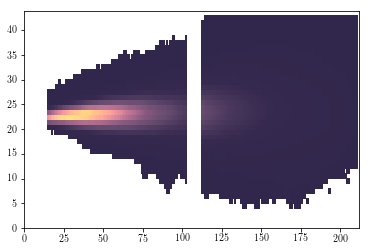

In [398]:
plt.pcolormesh(c_bar_w_bar,cmap='sunset')

In [ ]:
cw = W_inst*c_map
cw_bar = nma.mean(cw,axis=0)
np.savez_compress(path+'figures/avg_mass_flux.npz',cw_bar)

In [401]:
mf = []
for i in range(0,W_mean.shape[1]):
    mf.append(nma.sum(c_bar_w_bar[0:24,i]))

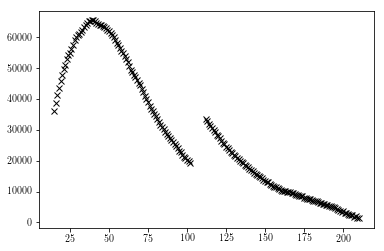

In [402]:
plt.plot(mf,'kx')